# Supplementary figures 4 and 5

This notebook contains the functions used to construct the supplementary figure 4 and 5 in the paper. 

The figures represents the relationship between decreased exonic mutation burden and exonic enrichment of H3K36me3 (read count based as well as peak based) across clusters of tumors.

Supplementary figure 4 is computed using the reads of the histon marks while supplementary figure 5 uses the peaks.

---

The data required for each panel is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [1]:
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import scipy.stats as stats
import seaborn as sns
from scipy.stats import chi2
from statsmodels.robust.robust_linear_model import RLM

from python_scripts.analysis_functions import remove_version_ensembl
from python_scripts.plot_functions import config_plot_params

In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
config_plot_params()

## Input

### Included files

Files in the **data** directory. There is more information about them in the ``README`` file in that folder.

- *clusters_file*: clusters of samples per tumor type
- *nucleosome coordinates*: nucleosome position data 

### Files not provided

These files are not included. There is more information about them in the ``README`` file located in the **non_provided_data/** folder.

- histone_data_folder: path to folder where the histon marks data files are. This notebook makes use of the reads information (files with the ``.tagAlign.gz`` extension) and the peaks (files with the ``.narrowPeaks.gz`` extension)

### Other

- tumors_histone: trio of tumor, cluster and histon cell to be analysed
- bins: size of the different bins in which to group the genes

---

In addition, this notebook requires the output of **sequences_filtering** and **gene_and_sample_analysis** notebooks.

In [5]:
# Included
clusters_file = 'data/clusters.tsv'
coordinates = 'data/coordinates'

# Protected
#histone_data_folder = 'non_provided_data/histonmarks/'
histone_data_folder = '/workspace/projects/intron_exon_mut_rate/data/histone_marks/'

# Other
# Colorectal Carcinoma POLE-mutant and MSH-H and bMMRD POLE and POLD-mutant
tumors_histone = [('crc', 'clusterA', 'E075-H3K36me3'), ('crc', 'clusterB', 'E075-H3K36me3'), ('bMMRD', 'clusterA', 'E067-H3K36me3'), ('bMMRD', 'clusterB', 'E067-H3K36me3')]
bins = [10, 25, 50]

## Analysis

Compute the decrease in exonic mutation rate  grouping the genes by the coverage of a histon mark reads or peaks.

See section **Relationship between decrease of exonic mutation rate and exonic H3K36me3 enrichment** for more details.

Note that the code is the same as the one used in figure 4, with the difference that now a list of bins in accepted.

In [6]:
def add_muts(x, y, samplelvl_results_df):
    
    my_gene = x['ensembl']
    sub_samplelvl = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]
    
    exon_muts = sum(sub_samplelvl[y])
    
    return exon_muts

def compute_pval(obs_muts_1, obs_muts_2, exp_muts1_prob):
    """likelihood ratio test"""
    
    y = obs_muts_1
    N = obs_muts_1 + obs_muts_2
    p1 = y/N #probability of going exon according to the observed exon/intron muts

    p0 = exp_muts1_prob #expected probability of going exon
    
    logL1 = y*np.log(p1)+(N-y)*np.log(1-p1) #log likelihood according to p1
    logL0 = y*np.log(p0)+(N-y)*np.log(1-p0) #log likelihood according to p0
        
    my_chi2 = 2*(logL1-logL0)
    
    my_p = chi2.sf(my_chi2, 1) #chi2 score to pvalue
    
    return my_p

In [7]:
def compute_data(tumor_type, cluster_id, histon_mark, bins_size, use_peaks):
    print(tumor_type, cluster_id)
    
    clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)
    sub_clust = clusters_df[clusters_df['ctype'] == tumor_type]
    
    histon_marks_lol = list()
    
    #Read precomputed results
    gene_dependent_results = path.join('results', "%s_%s_gene_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other notebook
    sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other notebook

    genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
    samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')
        
    my_genes =  genelvl_results_df['ensembl'].tolist()

    my_genelevel_exp = list()

    ########
    #The goal of this first part is to get the number of obs & exp muts per gene
    #######

    #Iterate genes, computing the observed and expected intronic and exonic mutations
    #Also computes the expected syn and nonsyn muts, but i think its not needed
        
    for my_gene in my_genes:
        sub_genelvl_results = genelvl_results_df[genelvl_results_df['ensembl'] == my_gene]
        sub_samplelvl_results = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]

        exons_products_sum = sub_genelvl_results['exons_products_sum'].values[0]
        introns_products_sum = sub_genelvl_results['introns_products_sum'].values[0]

        exons_prob = exons_products_sum/(exons_products_sum+introns_products_sum)
        introns_prob = introns_products_sum/(exons_products_sum+introns_products_sum)

        exon_muts = sum(sub_samplelvl_results['obs_exon_muts'])
        intron_muts = sum(sub_samplelvl_results['obs_intron_muts'])

        total_muts = exon_muts+intron_muts

        exp_exon_muts = total_muts*exons_prob
        exp_intron_muts = total_muts*introns_prob

        syn_products_sum = sub_genelvl_results['syn_products_sum'].values[0]
        nonsyn_products_sum = sub_genelvl_results['nonsyn_products_sum'].values[0]

        syn_prob = syn_products_sum/(syn_products_sum+nonsyn_products_sum)
        nonsyn_prob = nonsyn_products_sum/(syn_products_sum+nonsyn_products_sum)

        syn_muts = sum(sub_samplelvl_results['obs_syn_muts'])
        nonsyn_muts = sum(sub_samplelvl_results['obs_nonsyn_muts'])

        total_cons_muts = syn_muts+nonsyn_muts

        exp_syn_muts = total_cons_muts*syn_prob
        exp_nonsyn_muts = total_cons_muts*nonsyn_prob

        exons_bp = sub_genelvl_results['exons_bp'].values[0]
        introns_bp = sub_genelvl_results['introns_bp'].values[0]

        my_genelevel_exp.append([my_gene, exon_muts, exp_exon_muts, intron_muts,
                                 exp_intron_muts, syn_muts, exp_syn_muts, nonsyn_muts,
                                 exp_nonsyn_muts, exons_bp, introns_bp])

    my_genelevel_exp_df = pd.DataFrame(my_genelevel_exp)
    my_genelevel_exp_df.columns = ['ensembl', 'exon_muts', 'exp_exon_muts', 'intron_muts',
                                   'exp_intron_muts', 'syn_muts', 'exp_syn_muts', 'nonsyn_muts',
                                   'exp_nonsyn_muts', 'exons_bp', 'introns_bp']

        
    ########
    #The goal of this second part is to get two histone mark values per gene:
    #One for the exons and one for the introns. 
    #######
    
    
    if use_peaks:
        histone_type = 'peaks'
    else:
        histone_type = 'reads'

    # Loads exon and intron coordinates
    print(histon_mark, histone_type)
    
    # As we do not have this data for bMMRD, we use gbm data
    if tumor_type == 'bMMRD':
        introns_coords = path.join(coordinates, 'gbm_filtered_introns_coords.txt')  # Output from other notebook
        middle_exons_coords = path.join(coordinates, 'gbm_filtered_exons_coords.txt')  # Output from other notebook
    else:        
        introns_coords = path.join(coordinates, '%s_filtered_introns_coords.txt' % tumor_type)  # Output from other notebook
        middle_exons_coords = path.join(coordinates, '%s_filtered_exons_coords.txt' % tumor_type)  # Output from other notebook
        
    if use_peaks:
        ext = '.narrowPeak.gz'
    else:
        ext = '.tagAlign.gz'
    
    # process file depends on if it is histone mark or nuclesome data
    if histon_mark != 'nucleosome':
        histone_reads_file = path.join(histone_data_folder, '{}{}'.format(histon_mark, ext))
        histone_data_df = pd.read_csv(histone_reads_file, sep='\t', header=None)
        histone_data_df = histone_data_df[[0,1,2]]
        histon_mark_bed = pybedtools.BedTool.from_dataframe(histone_data_df)
    else:
        histone_reads_file = path.join('data', 'nucleosome_coords.bed')
        histone_data_df = pd.read_csv(histone_reads_file, sep='\t', header=None)
        histone_data_df = histone_data_df[histone_data_df[3] >= 2.5] # select histones with high scores
        histone_data_df = histone_data_df[[0,1,2]]
        histone_data_df[1] = histone_data_df[1] - 73 #nucleosome start
        histone_data_df[2] = histone_data_df[2] + 73 #nucleosome end
        histone_data_df = histone_data_df[~histone_data_df[1] < 0]
        histon_mark_bed = pybedtools.BedTool.from_dataframe(histone_data_df)

    exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", low_memory=False)
    exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
    exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
    sub_exons_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_df)
    my_exon_histon_bed = sub_exons_coords_bed.intersect(histon_mark_bed, wao=True)
    my_exon_histon_df = pd.read_table(my_exon_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                            'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
    my_exons_reads = my_exon_histon_df.groupby('ensembl')['overlap_bp'].sum()
    my_exons_reads = pd.DataFrame({'ensembl':my_exons_reads.index, 'exon_bases_covered':my_exons_reads.values})
    
    introns_coords_df = pd.read_csv(introns_coords, sep="\t", low_memory=False)
    introns_coords_df['ensembl'] = introns_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
    introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
    sub_introns_coords_bed = pybedtools.BedTool.from_dataframe(introns_coords_df)
    my_intron_histon_bed = sub_introns_coords_bed.intersect(histon_mark_bed, wao=True)
    my_intron_histon_df = pd.read_table(my_intron_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                            'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
    my_introns_reads = my_intron_histon_df.groupby('ensembl')['overlap_bp'].sum()
    my_introns_reads = pd.DataFrame({'ensembl':my_introns_reads.index, 'intron_bases_covered':my_introns_reads.values})

    my_merged_histon_reads = pd.merge(my_exons_reads, my_introns_reads, on='ensembl')


    ########
    #Next, it bins the genes based on the exon / intron proportion of the histone mark
    #######
    
    for bin_size in bins_size:
        print('Bin {}'.format(bin_size))

        sub_results = genelvl_results_df

        sub_results['exon_muts'] = sub_results.apply(lambda x: add_muts(x, 'obs_exon_muts', samplelvl_results_df), axis=1)
        sub_results['intron_muts'] = sub_results.apply(lambda x: add_muts(x, 'obs_intron_muts', samplelvl_results_df), axis=1)

        sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                                    (sub_results['exons_bp'] + sub_results['introns_bp']))
        sub_results = sub_results[sub_results['mutrate'] != 0]

        sub_results_histon = pd.merge(sub_results, my_merged_histon_reads, on='ensembl')

        sub_results_histon['exons_histon_rate'] = (sub_results_histon['exon_bases_covered']/
                                                   sub_results_histon['exons_bp'])
        sub_results_histon['introns_histon_rate'] = (sub_results_histon['intron_bases_covered']/
                                                     sub_results_histon['introns_bp'])
        sub_results_histon['total_histon_rate'] = ((sub_results_histon['intron_bases_covered'] + sub_results_histon['exon_bases_covered'])/
                                                     (sub_results_histon['introns_bp'] + sub_results_histon['exons_bp']))
        sub_results_histon['ex_in_histon_fc'] = sub_results_histon['exons_histon_rate']/sub_results_histon['introns_histon_rate']

        filtered_results_histon = sub_results_histon[(sub_results_histon['exon_bases_covered'] != 0) &
                                               (sub_results_histon['intron_bases_covered'] != 0)]

        filtered_results_histon = filtered_results_histon.sort_values(by='ex_in_histon_fc', ascending=True)

        groups_size = int(len(filtered_results_histon.index.tolist()) / bin_size)

        histon_levels = dict()

        for i in range(bin_size):
            my_start = i * groups_size
            my_end = (i + 1) * groups_size

            if i == max(range(bin_size)):
                my_end = len(filtered_results_histon.index.tolist())

            sub_exin_prop_df = filtered_results_histon.iloc[my_start:my_end]
            sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()

            histon_levels[i] = sub_exin_genes

        exons_results_prop = list()
        introns_results_prop = list()
        results_for_printing = list()


        ########
        #For each of the bins, compute the decreased mutarate
        #######


        for histon_level in histon_levels:
            genes_list = histon_levels[histon_level]

            my_median_ex_in_histon_fc = np.mean(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['ex_in_histon_fc'])
            my_std = filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['ex_in_histon_fc'].describe()['std']
            exons_bp = sum(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['exons_bp'])
            introns_bp = sum(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['introns_bp'])

            obs_exon_muts = sum(samplelvl_results_df[samplelvl_results_df['enembl'].isin(genes_list)]['obs_exon_muts'])
            obs_intron_muts = sum(samplelvl_results_df[samplelvl_results_df['enembl'].isin(genes_list)]['obs_intron_muts'])

            total_muts = obs_exon_muts+obs_intron_muts

            obs_exons_rate = obs_exon_muts/exons_bp
            obs_introns_rate = obs_intron_muts/introns_bp

            exp_exon_muts = sum(my_genelevel_exp_df[my_genelevel_exp_df['ensembl'].isin(genes_list)]['exp_exon_muts'])
            exp_intron_muts = sum(my_genelevel_exp_df[my_genelevel_exp_df['ensembl'].isin(genes_list)]['exp_intron_muts'])

            exp_exons_rate = exp_exon_muts/exons_bp
            exp_introns_rate = exp_intron_muts/introns_bp

            exons_results_prop.append([histon_level, 'exon', obs_exons_rate, exp_exons_rate, obs_exon_muts, exp_exon_muts, my_median_ex_in_histon_fc, my_std])
            introns_results_prop.append([histon_level, 'intron', obs_introns_rate, exp_introns_rate, obs_intron_muts, exp_intron_muts, my_median_ex_in_histon_fc, my_std])

            #Results for printing

            average_exons_reads = np.average(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['exon_bases_covered'])
            average_introns_reads = np.average(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['intron_bases_covered'])

            exp_exon_prob = exp_exon_muts/(obs_exon_muts+obs_intron_muts)

            my_p = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)

            my_row = [histon_level, average_exons_reads, average_introns_reads,
                      obs_exon_muts, obs_intron_muts, exp_exon_muts, exp_intron_muts, my_p,
                      'my_median_ex_in_histon_fc']

            results_for_printing.append(my_row)

        results_for_printing_df = pd.DataFrame(results_for_printing)
        results_for_printing_df.columns = ['histon_level', 'average_exons_reads', 'average_introns_reads',
                                          'obs_exon_muts', 'obs_intron_muts', 'exp_exon_muts', 'exp_introns_rate',
                                           'pvalue', 'median_fc']

        file_name = tumor_type + '_' + cluster_id + '_' + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type  + '_exon_intron_%s.txt' % histone_type

        results_for_printing_df.to_csv(path.join('results', file_name), sep='\t', header=True, index=None)

        results_prop_df = pd.concat([pd.DataFrame(exons_results_prop), pd.DataFrame(introns_results_prop)])
        results_prop_df.columns = ['bin', 'region', 'observed_mutrate', 'expected_mutrate', 'obs_muts', 'exp_muts', 'median_fc', 'std']

        results_prop_df['decrease_over_expected'] = -(results_prop_df['expected_mutrate']-results_prop_df['observed_mutrate'])/results_prop_df['expected_mutrate']*100

        ########
        #Prepare data
        #######

        tmp = results_prop_df[results_prop_df['region'] == 'exon'].copy()

        # Histon values per gene
        exin_bin_per_gene_lol = list()
        for histon_level in histon_levels:
            hist_level_genes  = histon_levels[histon_level]

            for my_gene in hist_level_genes:
                gene_exin = filtered_results_histon[ filtered_results_histon['ensembl'] == my_gene]['ex_in_histon_fc'].values.tolist()[0]
                exin_bin_per_gene_lol.append([histon_level, gene_exin])

        fc_histone = pd.DataFrame(exin_bin_per_gene_lol)
        fc_histone.columns = ['bin', 'ex_in_histon_fc']

        decrease = tmp[['decrease_over_expected']]
        decrease.index = tmp['bin']

        y_coords = []
        x_coords = []

        # Collapse histone values using the mean
        for ind in decrease.index:
            y_coords += [decrease.loc[ind, 'decrease_over_expected']]
            fc_histone_slice = fc_histone[fc_histone['bin'] == ind]
            x_coords += [np.mean(fc_histone_slice['ex_in_histon_fc'].values)]

        df = pd.DataFrame({'decrease_over_expected': y_coords, 'mean_fc': x_coords, 'bin': decrease.index})

        file_name = tumor_type + '_' + cluster_id + '_'  + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type  + '_exon_intron_reads.tsv'
        df.to_csv(path.join('results', file_name), sep='\t', header=True, index=None)

In [ ]:
for tumor_type, cluster_id, histon_cell in tumors_histone:
    compute_data(tumor_type, cluster_id, histon_cell, bins, use_peaks=True)
    compute_data(tumor_type, cluster_id, histon_cell, bins, use_peaks=False)

### Plots

Decrease of exonic mutation rate grouping genes by the coverage of intronic and exonic reads or peaks of certain histon mark

In [8]:
def provide_exog(covariate):
    exog_data = np.array(np.concatenate((np.array(covariate), np.ones_like(covariate))).reshape(2, len(covariate)))
    return np.transpose(exog_data)

def w_corr(x, y, w):
    '''weighted correlation'''
    return w_cov(x, y, w) / np.sqrt(w_cov(x, x, w) * w_cov(y, y, w))

def w_cov(x, y, w):
    '''weighted covariance'''
    return np.sum(w * (x - w_mean(x, w)) * (y - w_mean(y, w))) / np.sum(w)

def w_mean(x, w):
    '''weighted mean'''
    return np.dot(x, w) / np.sum(w)

def eformat(f, prec, exp_digits):
    s = "%.*e"%(prec, f)
    mantissa, exp = s.split('e')
    # add 1 to digits as 1 is taken by sign +/-
    return "%se%+0*d"%(mantissa, exp_digits+1, int(exp))

def do_plot(tumor_type, cluster_id, histon_mark, bin_size, ax, use_peaks):
    
    #fig = plt.figure(figsize=(4, 4))

    if use_peaks:
        histone_type = 'peaks'
    else:
        histone_type = 'reads'       
    
    #ax = fig.add_subplot(1, 1, 1)

    file_name = tumor_type + '_' + cluster_id + '_' + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type  + '_exon_intron_reads.tsv'
    data_df = pd.read_csv(path.join('results', file_name), sep="\t")
    
    # Log2 in the x axis if using peak data
    if use_peaks and histon_mark != 'nucleosome':
        data_df['mean_fc'] = data_df['mean_fc'].map(np.log2)

    x=data_df["mean_fc"].values.tolist()
    y=data_df["decrease_over_expected"].values.tolist()

    exog_data = provide_exog(y)
    model_irls = RLM(x, exog_data)

    res_irls = model_irls.fit()
    res_irls.summary2()

    pval = 2 * stats.t.sf(np.abs(res_irls.tvalues[0]), res_irls.df_resid)
    weighted_r = w_corr(x, y, res_irls.weights)

    sns.regplot(x="mean_fc", y="decrease_over_expected", data=data_df, color="#4c72b0", 
                scatter_kws={'s':10}, ax=ax, line_kws={'color':'#db2f34', 'lw':1})
    ax.set_ylim(-70, 30)

    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.set_ylabel('Decreased exonic mutation burden')
    #ax.set_xlabel(histon_mark.split('.')[0] + ' exon to intron ratio' + ('(log2)' if use_peaks else ''))

    ax.margins(0.05)

    for axis in ['right', 'top']:
        ax.spines[axis].set_visible(False)

    for axis in ['bottom', 'left']:
        ax.spines[axis].set_position(('axes', -0.01))

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.major.locator.set_params(nbins=6)

    ax.text(0.5, -45, 'r: ' + str(round(weighted_r, 2)), fontsize=7)
    ax.text(0.5, -60, 'p: ' + str(eformat(pval, 2, 2)), fontsize=7)

    print(tumor_type, cluster_id, bin_size, histon_mark, weighted_r, pval, "%.2f" % pval)

### Figure S4

Decrease of exonic mutation rate grouping genes by the coverage of intronic and exonic reads of certain histon marks (read count based)

crc clusterA 10 E075-H3K36me3 -0.947867449662 3.03376731409e-05 0.00
crc clusterA 25 E075-H3K36me3 -0.79806614346 2.63750777936e-06 0.00
crc clusterA 50 E075-H3K36me3 -0.677798110961 6.70872687201e-08 0.00
crc clusterB 10 E075-H3K36me3 0.316590715608 0.374773944491 0.37
crc clusterB 25 E075-H3K36me3 0.184314488128 0.4184184244 0.42
crc clusterB 50 E075-H3K36me3 0.123010188944 0.459325330392 0.46
bMMRD clusterA 10 E067-H3K36me3 0.134357773049 0.710923976472 0.71
bMMRD clusterA 25 E067-H3K36me3 0.0598746919107 0.781377367443 0.78
bMMRD clusterA 50 E067-H3K36me3 0.0694205598958 0.644804774985 0.64
bMMRD clusterB 10 E067-H3K36me3 -0.556581977158 0.123418341649 0.12
bMMRD clusterB 25 E067-H3K36me3 -0.366286342079 0.0670878371265 0.07
bMMRD clusterB 50 E067-H3K36me3 -0.248826218762 0.0983455732756 0.10


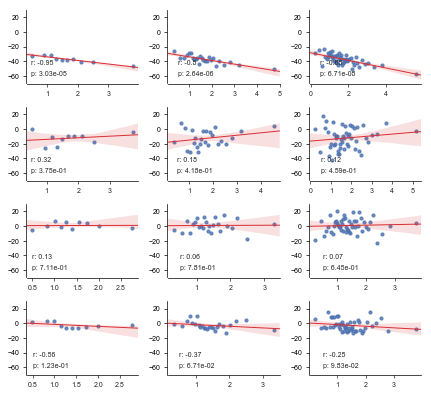

In [9]:
NROW = len(tumors_histone)
NCOL = len(bins)

fig = plt.figure(figsize=(6, 5.5))

axs=[]

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))
        
cnt=0

for i, val in enumerate(tumors_histone):
    tumor_type, cluster_id, histon_cell = val    
    for j, bin_size in enumerate(bins):
        do_plot(tumor_type, cluster_id, histon_cell, bin_size, axs[cnt], use_peaks=False)
        cnt+=1
        
plt.tight_layout()
plt.savefig(path.join('figures', 'figureS4.svg'), bbox_inches='tight')
plt.show()

### Figure S5

Decrease of exonic mutation rate grouping genes by the coverage of intronic and exonic reads of certain histon marks (peak based)

crc clusterA 10 E075-H3K36me3 -0.61643296127 0.048163152269 0.05
crc clusterA 25 E075-H3K36me3 -0.531362840622 0.00678902587431 0.01
crc clusterA 50 E075-H3K36me3 -0.380513365811 0.00986878181467 0.01
crc clusterB 10 E075-H3K36me3 0.0653806741744 0.874828132842 0.87
crc clusterB 25 E075-H3K36me3 0.056690892269 0.786677538106 0.79
crc clusterB 50 E075-H3K36me3 0.0388615983651 0.798159231351 0.80
bMMRD clusterA 10 E067-H3K36me3 -0.0790455308605 0.836471244369 0.84
bMMRD clusterA 25 E067-H3K36me3 -0.0710928535869 0.729118681659 0.73
bMMRD clusterA 50 E067-H3K36me3 -0.0162740631543 0.910752276435 0.91
bMMRD clusterB 10 E067-H3K36me3 0.06230734082 0.875090305951 0.88
bMMRD clusterB 25 E067-H3K36me3 0.032921999313 0.885446756845 0.89
bMMRD clusterB 50 E067-H3K36me3 0.0273316097022 0.859540539834 0.86


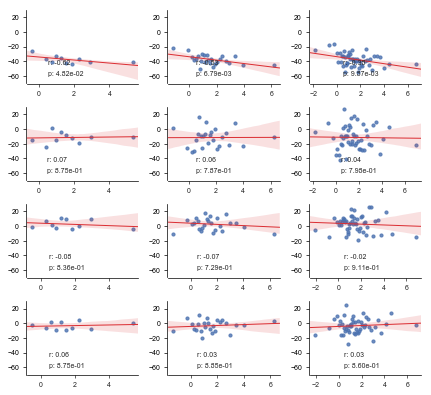

In [10]:
NROW = len(tumors_histone)
NCOL = len(bins)

fig = plt.figure(figsize=(6, 5.5))

axs=[]

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))
        
cnt=0

for i, val in enumerate(tumors_histone):
    tumor_type, cluster_id, histon_cell = val    
    for j, bin_size in enumerate(bins):
        do_plot(tumor_type, cluster_id, histon_cell, bin_size, axs[cnt], use_peaks=True)
        cnt+=1
        
plt.tight_layout()
plt.savefig(path.join('figures', 'figureS5.svg'), bbox_inches='tight')
plt.show()

Decrease of exonic mutation rate grouping genes by the coverage of intronic and exonic nucleosomes

In [ ]:
# generate data to plot
compute_data('crc', 'clusterA', 'nucleosome', bins, use_peaks=True)

crc clusterA 10 nucleosome 0.0161883458008 0.955340177062 0.96
crc clusterA 25 nucleosome 0.0421547234879 0.831217635313 0.83
crc clusterA 50 nucleosome 0.0245286678061 0.862678013232 0.86


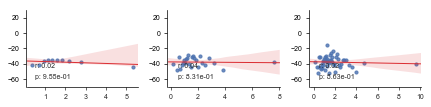

In [11]:
NROW = 1
NCOL = 3

fig = plt.figure(figsize=(6, 1.5))

axs=[]

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))
        
cnt=0
for j, bin_size in enumerate(bins):
    do_plot('crc', 'clusterA', 'nucleosome', bin_size, axs[cnt], use_peaks=True)
    cnt+=1
        
plt.tight_layout()
plt.savefig(path.join('figures', 'figureS5_nucleosome.svg'), bbox_inches='tight')
plt.show()